In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

from __future__ import division

import numpy as np
import os
#import mne
import pandas as pd
import matplotlib.pyplot as plt

from scipy import io, signal

from data_utils import *
from preprocessing import *
from models import *
from metrics import *
from plotting import *

import mne
from mpl_toolkits.mplot3d import Axes3D

from sklearn.linear_model import LogisticRegression as LR

no cv2... continuing...


Using Theano backend.
Using gpu device 0: Tesla K20c (CNMeM is disabled, cuDNN Version is too old. Update to v5, was 3007.)


In [2]:
delta = range(0,4)
theta = range(3,9)
alpha = range(8,13)
beta = range(12,40)

In [25]:
X_s, Y_s, Y_l, ch_dict = import_data(1, downsample=5, ch_dict=True,
                                    bp_range=(.5,40), filt='CAR')

# get channel positions

X, Y = X_s[0], Y_s[0]

Converting time column to int64...


In [39]:
(X_train, Y_train), (X_test, Y_test) = state_window(X, Y, 
                                                    label=3, num_wins=1)
Xw = np.concatenate([X_train, X_test])
Yw = np.concatenate([Y_train, Y_test])

Xf = map(lambda w: psd(w, 'welch').reshape(-1), Xw)





In [5]:
ch_ls = []
for key,value in sorted(ch_dict.items(), key=lambda x: x[1]):
    print key,value,'\t',
    ch_ls.append(key)
    
print "\n"

for key,value in sorted(ch_dict.items(), key=lambda x: x[0]):
    print key,value,'\t',

FP1 0 	FPZ 1 	FP2 2 	AF3 3 	AF4 4 	F7 5 	F5 6 	F3 7 	F1 8 	FZ 9 	F2 10 	F4 11 	F6 12 	F8 13 	FT7 14 	FC5 15 	FC3 16 	FC1 17 	FCZ 18 	FC2 19 	FC4 20 	FC6 21 	FT8 22 	T7 23 	C5 24 	C3 25 	C1 26 	CZ 27 	C2 28 	C4 29 	C6 30 	T8 31 	M1 32 	TP7 33 	CP5 34 	CP3 35 	CP1 36 	CPZ 37 	CP2 38 	CP4 39 	CP6 40 	TP8 41 	M2 42 	P7 43 	P5 44 	P3 45 	P1 46 	PZ 47 	P2 48 	P4 49 	P6 50 	P8 51 	PO7 52 	PO5 53 	PO3 54 	POZ 55 	PO4 56 	PO6 57 	PO8 58 	CB1 59 	O1 60 	OZ 61 	O2 62 	CB2 63 	VEO 64 	HEO 65 	EKG 66 	EMG 67 	Trigger 68 	STI 014 69 	

AF3 3 	AF4 4 	C1 26 	C2 28 	C3 25 	C4 29 	C5 24 	C6 30 	CB1 59 	CB2 63 	CP1 36 	CP2 38 	CP3 35 	CP4 39 	CP5 34 	CP6 40 	CPZ 37 	CZ 27 	EKG 66 	EMG 67 	F1 8 	F2 10 	F3 7 	F4 11 	F5 6 	F6 12 	F7 5 	F8 13 	FC1 17 	FC2 19 	FC3 16 	FC4 20 	FC5 15 	FC6 21 	FCZ 18 	FP1 0 	FP2 2 	FPZ 1 	FT7 14 	FT8 22 	FZ 9 	HEO 65 	M1 32 	M2 42 	O1 60 	O2 62 	OZ 61 	P1 46 	P2 48 	P3 45 	P4 49 	P5 44 	P6 50 	P7 43 	P8 51 	PO3 54 	PO4 56 	PO5 53 	PO6 57 	PO7 52 	PO8 58 	POZ 55 	PZ 47 	STI 014 

In [56]:
Xbp = bp_filter(X, .5, 40, fs=200)

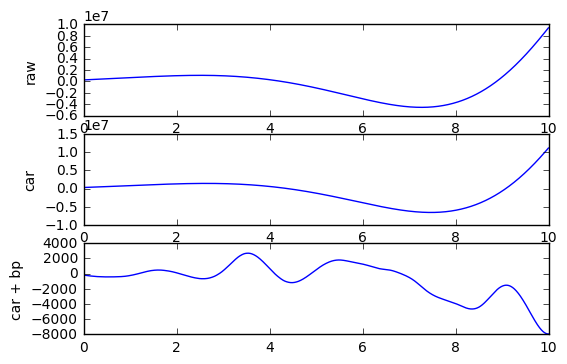

In [22]:
ch = 10 #12: FC6
x = X[:,ch]
x2 = CAR(X)[:,ch]
xbp2 = bp_filter(x, .5, 40, 200)

fs = 200
offset = fs * 20
T = fs * 10
t = np.arange(T)/fs

plt.subplot(3,1,1)
plt.plot(t,x[offset:offset+T])
plt.ylabel("raw")

plt.subplot(3,1,2)
plt.plot(t,x2[offset:offset+T])
plt.ylabel("car")

plt.subplot(3,1,3)
plt.plot(t,xbp2[offset:offset+T])
plt.ylabel("car + bp")

In [10]:
def process_windows(Xw, wtype='demean'):
    # i x ch x t
    if type(Xw) != type(np.arange(1)):
        Xw = np.asarray(Xw)
    if wtype == 'demean':
        return Xw - Xw.mean((2))[:,:,None]
    if wtype == 'zscore':
        return (Xw - Xw.mean((2))[:,:,None])/(Xw.std((2))[:,:,None])
    else:
        return Xw

preprocessing?: 


/home/UFAD/yliapis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


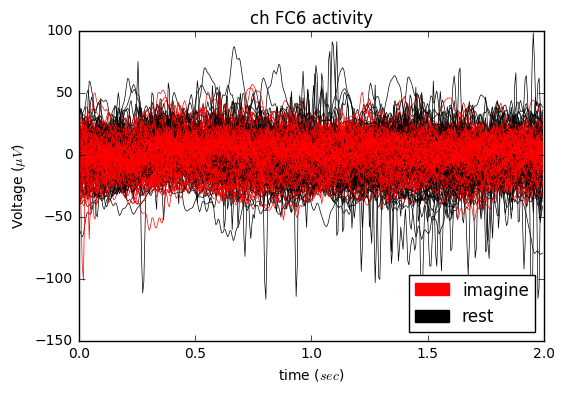

In [41]:
from matplotlib import collections  as mc
import matplotlib.patches as mpatches

plt.show()
ch=12

# ttt = np.arange(0, np.size(Xw, -1))/200
# t = [ttt for _ in Xw]
# lines = zip(t, map(lambda w: w[ch,:], Xw))
# c = np.array(['b', 'r'])[np.array(Yw, dtype=int)]

# lc = mc.LineCollection(lines, colors=c, linewidths=2)

# fig, ax = pl.subplots()
# ax.add_collection(lc)
t = np.arange(400)/200
c_arr = np.array(['k', 'r'])


Xplt = process_windows(Xw, raw_input("preprocessing?: "))

for w,y in zip(Xplt[:,ch,:], Yw):
    plt.plot(t, w, c=c_arr[y], linewidth=.5)

plt.xlabel("time ($sec$)")
plt.ylabel("Voltage ($\mu$$V$)")
plt.title("ch FC6 activity")

red_patch = mpatches.Patch(color='red', label='imagine')
black_patch = mpatches.Patch(color='black', label='rest')
plt.legend(handles=[red_patch, black_patch], loc=4)

/home/UFAD/yliapis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


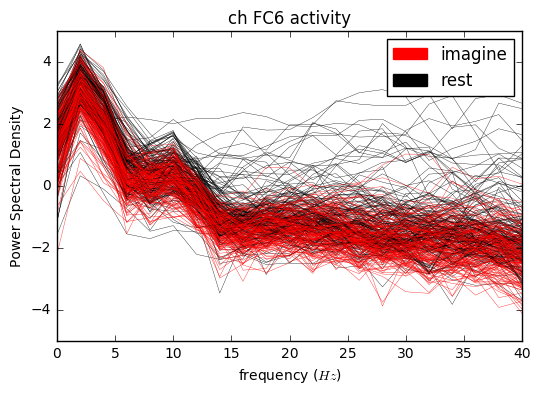

In [44]:
mapper = lambda win: psd(win, 'welch')
Xwf = map(mapper, Xw)

f = np.linspace(0,40, np.size(Xwf, 2))

Xplt = np.asarray(Xwf)
for w,y in zip(Xplt[:,ch,:], Yw):
    #dim(w)
    plt.plot(f, np.log(w), c=c_arr[y], linewidth=.25)

plt.xlabel("frequency ($Hz$)")
plt.ylabel("Power Spectral Density")
plt.title("ch FC6 activity")

red_patch = mpatches.Patch(color='red', label='imagine')
black_patch = mpatches.Patch(color='black', label='rest')
plt.legend(handles=[red_patch, black_patch], loc=1)

In [33]:
dim(Xwf)

296 62 21 


/home/UFAD/yliapis/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


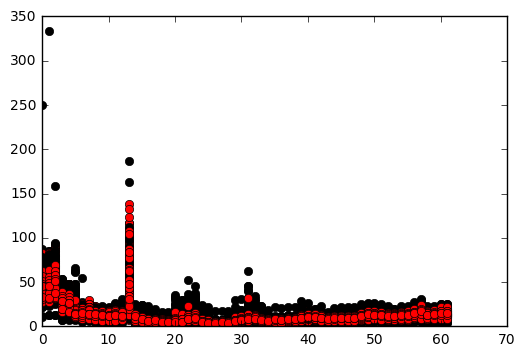

In [31]:
stds = np.std(Xw, (2))

for s,y in zip(stds, Yw):
    plt.plot(s, c=c_arr[y], marker='o',linestyle='None')


In [157]:
dim(lines)

329 2 400 


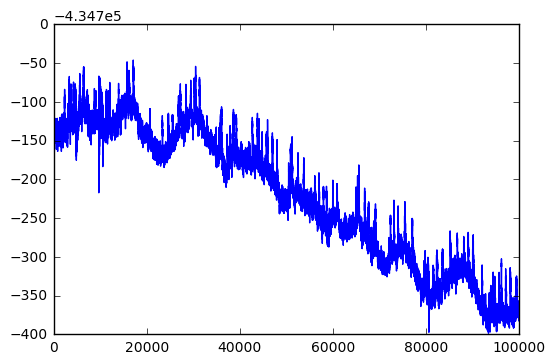

In [141]:
xsum = np.sum(X, 1)
plt.plot(xsum[0:100000])

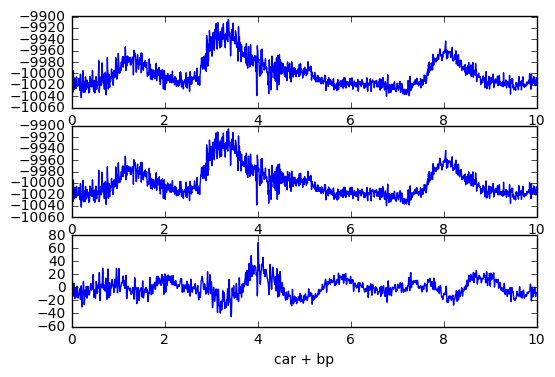

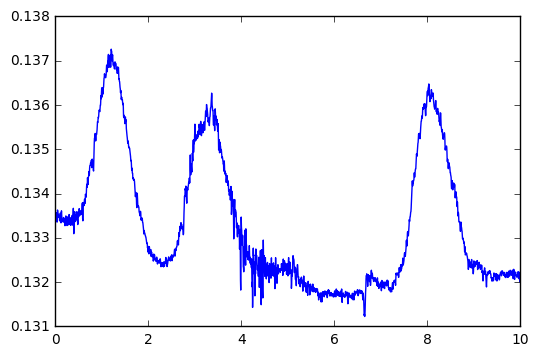

In [78]:
def nmse(x1, x2):
    return (x1-x2)**2/(x1**2+x2**2)



mse = nmse(X[:,1], CAR(X)[:,1])

plt.plot(t, mse[offset:offset+T])

In [18]:
def CAR(X, mode='mean'):
    # assuming t x ch
    if mode=='mean':
        return X - np.mean(X, 1)[:,None]
    elif mode=='zscore':
        return (X - np.mean(X, 1)[:,None])/np.std(X, 1)[:,None]
    
Xcm = CAR(X, 'mean')
Xcz = CAR(X, 'std')

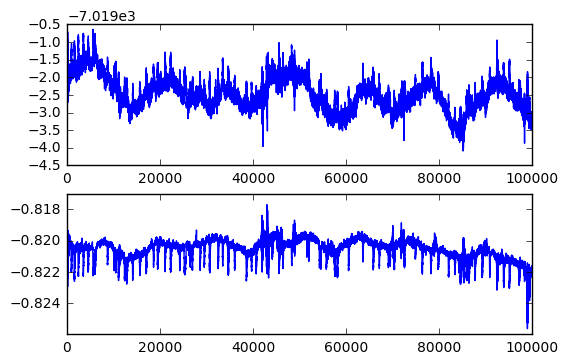

In [74]:
plt.subplot(2,1,1)
plt.plot(np.mean(X, 1)[400000:500000])
plt.subplot(2,1,2)
plt.plot((np.mean(X,1)/np.std(X,1))[400000:500000])

In [4]:
bp_range = (.5,40)
XXr, YYr = import_data_chunks(-1, state="clearing_inds",
                            downsample=5, bp_range=bp_range)
XXt, YYt = import_data_chunks(-1, state="thinking_inds",
                            downsample=5, bp_range=bp_range)
f = lambda x,y: (x[3], y[3])
Xr, Yr = f(XXr, YYr)
Xt, Yt = f(XXt, YYt)

Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
inconsistent number of epochs and labels:                        
	 expected:132 have:132
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...
Converting time column to int64...


In [7]:
dim(XXr)

13 165 995 62 


In [40]:
#trim

if raw_input("trim series? ") == 'y':
    print "trimming to 2000 ms"
    mapper = lambda win: win[:,:400]
    XXr, XXt = rec_map(mapper, [XXr, XXt], 3)
    

trim series? y
trimming to 2000 ms


In [ ]:
pdiff = lambda y,y_hat : 2*(y-y_hat)/(y+y_hat)

Pdiff = pdiff(PPr, PPt)

plt.imshow(Pdiff)
plt.colorbar()

In [ ]:
plt.plot(np.mean(Pdiff, 0))

In [39]:
XXr[0][0].shape

(995, 62)

In [ ]:
tick = 1
Pdiff = []
Pr, Pt = [], []
for Xr, Xt in zip(XXr, XXt):
    xrf, xtf = rec_map(psd, [Xr, Xt], 2)
    rm, tm = map(lambda d: np.mean(d,0), [xrf, xtf])
    pdiff = 2*(tm-rm)/(rm+tm)
    
    #
    Pdiff.append(pdiff)
    Pr.append(rm)
    Pt.append(tm)
    #
    plt.figure(tick)
    plt.imshow(pdiff, aspect='auto')
    plt.colorbar()
    tick += 1
    
    

In [34]:
# for subj 1

def get_band(P, frange):
    return P[:,frange].mean(1)

P = Pdiff[2]

P_alpha = get_band(P, alpha)
P_beta = get_band(P, beta)
P_delta = get_band(P, delta)
P_theta = get_band(P, theta)

In [ ]:
from matplotlib.colorbar import Colorbar

In [ ]:

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
r = topoplot(P_theta, {'axes':ax, 'vmin':-2, 'vmax':2})
#plt.colorbar()
plt.figure(2)
#plt.plot(P_theta)

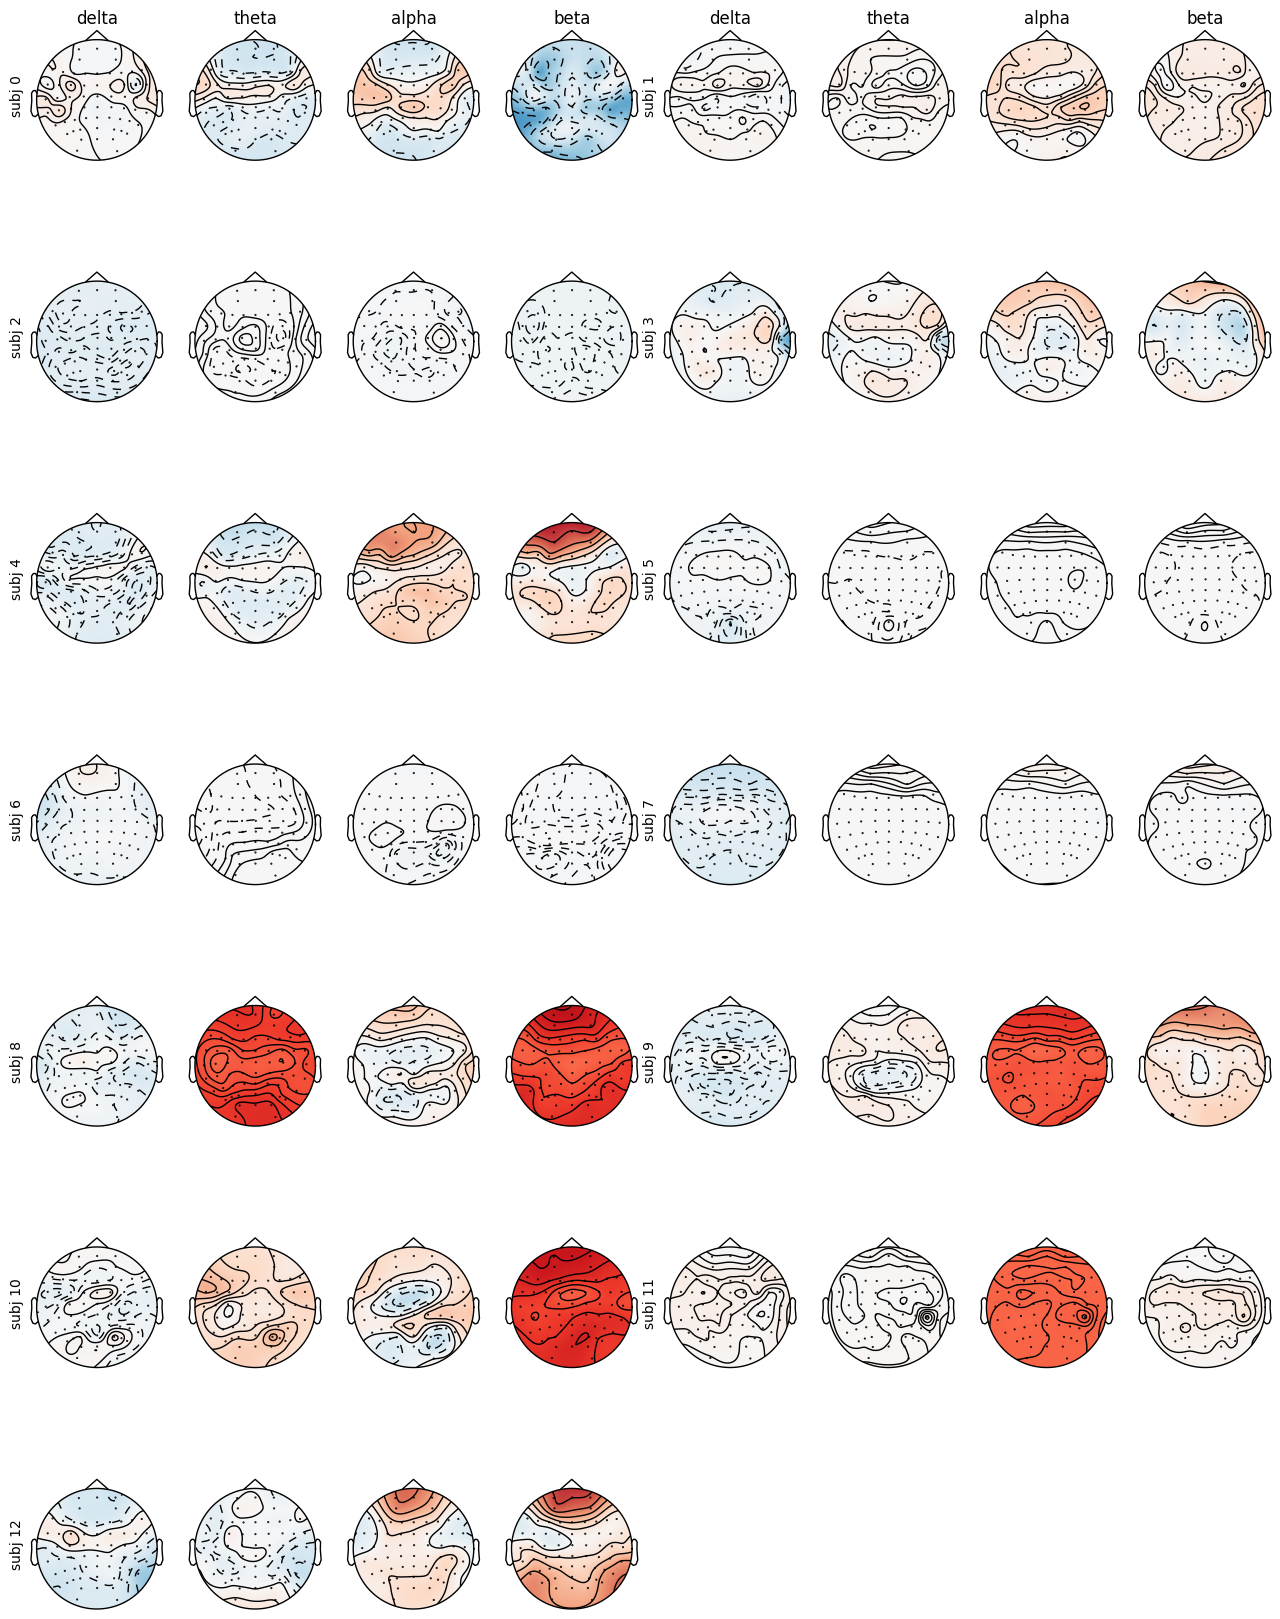

In [42]:

tick = 1
fig = plt.figure(figsize=(16,20))

for P in Pdiff:
    for frange in [delta, theta, alpha, beta]:
        ax = plt.subplot(7, 8, tick)
        #ax.imshow(np.random.rand(100,100))
        im, x = topoplot(get_band(P, frange), {'axes': ax, 'vmin':-1.5, 'vmax':1.5})
        if tick%4==1:
            plt.ylabel("subj {}".format(tick//4))
        if tick <=8:
            ax.title.set_text("delta theta alpha beta".split()[(tick-1)%4])
        #if tick == 13*4:
            #im.colorbar()
        tick += 1
        

In [ ]:
type(r[0])

In [17]:
data = np.loadtxt("sensor_loc.txt", dtype=float)
data = data.astype(float)

In [ ]:
for P in Pdiff:
    print np.min(P)
    print np.max(P)

In [85]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

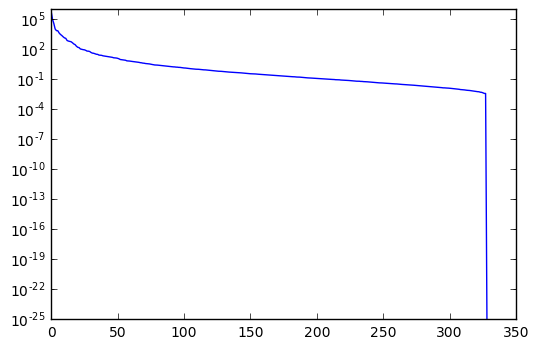

In [108]:
pca = PCA()
Xpca = pca.fit_transform((Xf))

plt.semilogy(pca.explained_variance_)

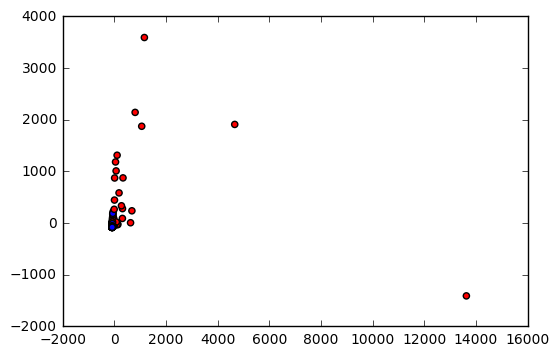

In [115]:
cols = np.array(['r','b'])[np.array(Yw, dtype=int)]

pts = #Xpca[:,:2].T
plt.scatter(*pts,c=cols)

In [121]:
from mpl_toolkits.mplot3d import Axes3D

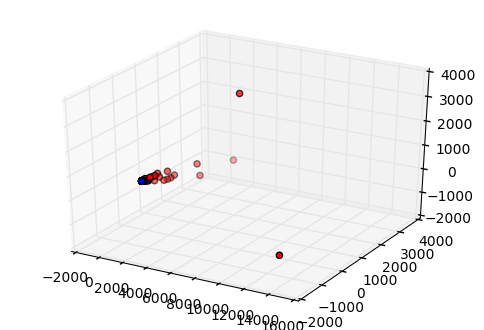

In [126]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(*Xpca[:,:3].T, c=cols)

In [112]:
dim(Xpca)

329 329 


1


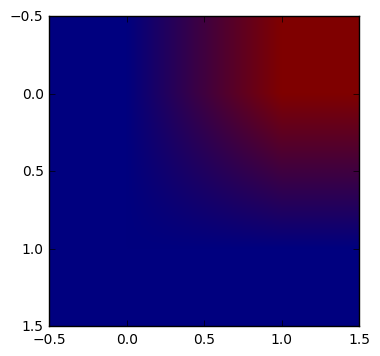

In [120]:
A = np.array([[0,1],[0,0]])

print A[0,1]

plt.imshow(A)